In [63]:
import tarfile
import pandas as pd
import glob
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt

reading all csv files from folder

In [64]:
path = './india/'
files = glob.glob(path + '/*.csv')

temperatures = []

for filename in range(4):
    d = pd.read_csv(files[filename])
    temperatures.append(list(d.loc[d['YEAR'] == 2019]['TEMPERATURE']))


checking the files has any error data

In [65]:
x = list(d.loc[d['YEAR'] == 2019]['TEMPERATURE'])
count = 0
for i in x:
    if i < 0:
        count += 1
count

0

list of dates

In [66]:
days = list(d.loc[d['YEAR'] == 2019]['DAY'])
m_d = []
mon = 0
for i in days:
    if i == 1:
        mon += 1
    m_d.append(f'{i}/{mon}/2019')



building dataframe from above data

In [67]:
cities = ['Chennai', 'Delhi', 'Kolkata', 'Mumbai']
df = pd.DataFrame(temperatures, columns=m_d, index=cities)

In [68]:
df

,1/1/2019,2/1/2019,3/1/2019,4/1/2019,5/1/2019,6/1/2019,7/1/2019,8/1/2019,9/1/2019,10/1/2019,...,2/8/2019,3/8/2019,4/8/2019,5/8/2019,6/8/2019,7/8/2019,8/8/2019,9/8/2019,10/8/2019,11/8/2019
Chennai,74.9,75.9,75.9,76.5,76.6,77.0,76.8,76.6,76.5,76.9,...,88.3,90.0,89.9,87.0,88.8,89.4,91.1,91.6,90.2,92.0
Delhi,55.0,56.8,56.3,54.0,55.8,57.1,55.8,56.4,56.3,54.0,...,87.7,86.0,87.5,89.2,81.0,87.7,92.3,88.7,87.9,91.2
Kolkata,62.8,64.8,63.6,62.4,62.9,65.4,66.1,65.7,64.6,63.7,...,84.9,84.9,84.3,87.9,83.0,80.5,80.3,84.9,86.6,88.0
Mumbai,76.7,77.9,77.8,79.3,76.7,76.5,78.2,77.4,75.6,77.9,...,80.1,79.5,81.2,82.9,82.5,82.6,82.9,82.6,83.5,83.2


In [69]:
def DMD(df, window):
    df1 = df[df.columns[:window-1]]
    df2 = df[df.columns[1:window]]

    X1 = df1.values
    X2 = df2.values


    U, S, Vh = linalg.svd(X1, full_matrices=False)
    r = min(np.linalg.matrix_rank(X1), U.shape[1])

    U_r = U[:, :r]
    S_r = np.diag(S[:r])
    V_r = Vh[:r, :]

    # A_tilde = np.dot(U.T, np.dot(Xt, np.dot(Vh.T, np.linalg.inv(sigma))))
    A_tilde = U_r.conj().T @ X2 @ V_r.conj().T @ np.linalg.inv(S_r)

    eig_val, eig_vec = np.linalg.eig(A_tilde)

    # phi = (Xt @ Vh.T @ np.linalg.inv(sigma) @ eig_vec)
    phi = X2 @ V_r.conj().T @ np.linalg.inv(S_r) @ eig_vec

    # freq = np.log(eig_val)

    x1 = X1[:,0]
    b = np.linalg.pinv(phi) @ x1   # amplitudes

    return phi, eig_val, b
    


In [70]:
def predict(window, days, phi, freq, b):
    t1 = np.linspace(1,10,100)
    dt = t1[1]-t1[0]
    t_dyn = np.zeros((window-1,days))
    t = np.arange(0,days)*dt

    for iter in range(days):
        t_dyn[:, iter] = b * np.exp(freq * t[iter])

    x_dmd = np.dot(phi, t_dyn)
    return x_dmd

In [71]:
def rmse(org,pred):
    out = []
    cities = ['Chennai', 'Delhi', 'Kolkata', 'Mumbai']
    t = (org-pred.real)**2
    for i in range(4):
        x = np.mean(t.loc[cities[i]])
        out.append(np.sqrt(x))
    return out


In [72]:
window = int(input('enter window size = '))

In [73]:
phi, freq, b = DMD(df, window)


In [74]:
# days_want_to_predict = int(input('No.of days you want to predict = '))
days_want_to_predict = 1
org = df[df.columns[window:window+days_want_to_predict]]
pred = predict(window, days_want_to_predict, phi, freq, b)
err1 = rmse(org, pred)
err1

C:\Users\rchar\AppData\Local\Temp\ipykernel_21764\3889421443.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  t_dyn[:, iter] = b * np.exp(freq * t[iter])


[2.088034339653376, 2.052131011156895, 2.5495173638135498, 0.20929206356369434]

In [75]:
np.mean(err1)

1.7247436945468788

In [76]:
# days_want_to_predict = int(input('No.of days you want to predict = '))
days_want_to_predict = 3
org2 = df[df.columns[window:window+days_want_to_predict]]
pred = predict(window, days_want_to_predict, phi, freq, b)
err2 = rmse(org2, pred)
err2

C:\Users\rchar\AppData\Local\Temp\ipykernel_21764\3889421443.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  t_dyn[:, iter] = b * np.exp(freq * t[iter])


[8.404636859526612, 6.321083064785086, 6.077617704575649, 9.200049413388387]

In [77]:
np.mean(err2)

7.500846760568933

In [78]:
# days_want_to_predict = int(input('No.of days you want to predict = '))
days_want_to_predict = 5
org3 = df[df.columns[window:window+days_want_to_predict]]
pred = predict(window, days_want_to_predict, phi, freq, b)
err3 = rmse(org3, pred)
err3

C:\Users\rchar\AppData\Local\Temp\ipykernel_21764\3889421443.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  t_dyn[:, iter] = b * np.exp(freq * t[iter])


[18.3037428856565, 14.366877465006219, 15.308764924364324, 19.92441124378809]

In [79]:
np.mean(err3)

16.975949129703782

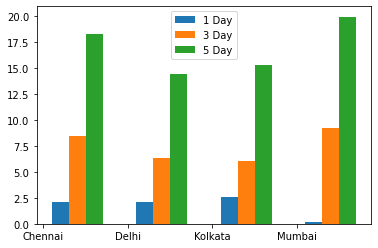

In [86]:
x_axis = np.arange(len(err1))
cities = ['Chennai', 'Delhi', 'Kolkata', "Mumbai"]
plt.bar(x_axis +0.20, err1, width=0.2, label='1 Day')
plt.bar(x_axis +0.20*2, err2, width=0.2, label='3 Day')
plt.bar(x_axis +0.20*3, err3, width=0.2, label='5 Day')
plt.xticks(x_axis, cities)
plt.legend()
plt.show()